# 製品プライサーは継続しました

その説明から、何かがどれだけの費用がかかるかを推定できるモデル。

## 最後に - ファインチューニングの時です！

このデータの準備と古い機械学習の後、私たちはついにあなたが待っていた瞬間に到着しました。モデルのファインチューニング。

In [1]:
# import

import os
import re
import random
import math
import json
import pickle

from dotenv import load_dotenv
from huggingface_hub import login

import numpy as np
from collections import Counter, defaultdict
from datasets import load_dataset, Dataset, DatasetDict
import matplotlib.pyplot as plt

from openai import OpenAI
#from anthropic import Anthropic

In [2]:
# environment

load_dotenv(override=True)
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY', 'your-key-if-not-using-env')
#os.environ['ANTHROPIC_API_KEY'] = os.getenv('ANTHROPIC_API_KEY', 'your-key-if-not-using-env')
os.environ['HF_TOKEN'] = os.getenv('HF_TOKEN', 'your-key-if-not-using-env')

In [3]:
# Hugging Faceにログイン

hf_token = os.environ['HF_TOKEN']
login(hf_token, add_to_git_credential=True)

Token has not been saved to git credential helper.
Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


Cannot authenticate through git-credential as no helper is defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub.
Run the following command in your terminal in case you want to set the 'store' credential helper as default.

git config --global credential.helper store

Read https://git-scm.com/book/en/v2/Git-Tools-Credential-Storage for more details.


In [4]:
# もう1つのインポート - Item クラスに加え Tester
# Testerを別のパッケージに移動（day3で既出なのでtesting.pyにはコメント追加してません）

from items import Item
from testing import Tester

In [5]:
openai = OpenAI()

In [6]:
# JupiterNotebookでmatplotlibを表示できるようにする。
%matplotlib inline

In [7]:
# すべてのデータを再度キュレーションすることを避けましょう！ピクルスファイルにロード：

with open('train.pkl', 'rb') as file:
    train = pickle.load(file)
with open('test.pkl', 'rb') as file:
    test = pickle.load(file)

In [8]:
# OpenAIは、50〜100件の例個体群でのファインチューニングを推奨している
# https://platform.openai.com/docs/guides/supervised-fine-tuning?utm_source=chatgpt.com
# しかし、この例は（180トークンと）非常に小さいので、200例（/ 1エポック）で行くことを提案

fine_tune_train = train[:200]
fine_tune_validation = train[200:250]

# ステップ1

JSONL（JSON Lines）形式でファインチューニングするためにデータを準備し、OpenAIにアップロード

In [9]:
# まずは、フロンティアモデル向けに良いプロンプトを作ってみましょう。
# items.pyの中で設定した「1ドル単位で」(to the nearest dollar) という文言を取り除いていることに注目してください。
# 私たちが自前のモデルをトレーニングする場合、問題をできるだけ簡単にする必要がありますが、フロンティアモデルにはそのような簡略化は必要ありません。
def messages_for(item):
    system_message = "You estimate prices of items. Reply only with the price, no explanation"
    user_prompt = item.test_prompt().replace(" to the nearest dollar","").replace("\n\nPrice is $","")
    return [
        {"role": "system", "content": system_message},
        {"role": "user", "content": user_prompt},
        {"role": "assistant", "content": f"Price is ${item.price:.2f}"}
    ]

In [10]:
# プロンプト生成をテスト

messages_for(train[0])

[{'role': 'system',
  'content': 'You estimate prices of items. Reply only with the price, no explanation'},
 {'role': 'user',
  'content': 'How much does this cost?\n\nDelphi FG0166 Fuel Pump Module\nDelphi brings 80 years of OE Heritage into each Delphi pump, ensuring quality and fitment for each Delphi part. Part is validated, tested and matched to the right vehicle application Delphi brings 80 years of OE Heritage into each Delphi assembly, ensuring quality and fitment for each Delphi part Always be sure to check and clean fuel tank to avoid unnecessary returns Rigorous OE-testing ensures the pump can withstand extreme temperatures Brand Delphi, Fit Type Vehicle Specific Fit, Dimensions LxWxH 19.7 x 7.7 x 5.1 inches, Weight 2.2 Pounds, Auto Part Position Unknown, Operation Mode Mechanical, Manufacturer Delphi, Model FUEL PUMP, Dimensions 19.7'},
 {'role': 'assistant', 'content': 'Price is $226.95'}]

In [11]:
# 項目をJSONオブジェクトのリスト（「jsonl」文字列）に変換、各行は次の形式
# {"messages" : [{"role": "system", "content": "You estimate prices...


def make_jsonl(items):
    result = ""
    for item in items:
        messages = messages_for(item)
        messages_str = json.dumps(messages)
        result += '{"messages": ' + messages_str +'}\n'
    return result.strip()

In [12]:
# jsonl変換をテスト

print(make_jsonl(train[:3]))

{"messages": [{"role": "system", "content": "You estimate prices of items. Reply only with the price, no explanation"}, {"role": "user", "content": "How much does this cost?\n\nDelphi FG0166 Fuel Pump Module\nDelphi brings 80 years of OE Heritage into each Delphi pump, ensuring quality and fitment for each Delphi part. Part is validated, tested and matched to the right vehicle application Delphi brings 80 years of OE Heritage into each Delphi assembly, ensuring quality and fitment for each Delphi part Always be sure to check and clean fuel tank to avoid unnecessary returns Rigorous OE-testing ensures the pump can withstand extreme temperatures Brand Delphi, Fit Type Vehicle Specific Fit, Dimensions LxWxH 19.7 x 7.7 x 5.1 inches, Weight 2.2 Pounds, Auto Part Position Unknown, Operation Mode Mechanical, Manufacturer Delphi, Model FUEL PUMP, Dimensions 19.7"}, {"role": "assistant", "content": "Price is $226.95"}]}
{"messages": [{"role": "system", "content": "You estimate prices of items. 

In [13]:
# アイテムをjsonlに変換しファイルに書込

def write_jsonl(items, filename):
    with open(filename, "w") as f:
        jsonl = make_jsonl(items)
        f.write(jsonl)

In [14]:
# trainをjsonlに書込
write_jsonl(fine_tune_train, "fine_tune_train.jsonl")

# openaiにjsonl (train) をアップロード
with open("fine_tune_train.jsonl", "rb") as f:
    train_file = openai.files.create(file=f, purpose="fine-tune")

# ファイルのハンドラ的なもの
train_file

FileObject(id='file-CcM7rkcVks9HWESfMSa4Rs', bytes=188543, created_at=1754404305, filename='fine_tune_train.jsonl', object='file', purpose='fine-tune', status='processed', expires_at=None, status_details=None)

In [15]:
# validationをjsonlに書込
write_jsonl(fine_tune_validation, "fine_tune_validation.jsonl")

# openaiにjsonl (validation) をアップロード
with open("fine_tune_validation.jsonl", "rb") as f:
    validation_file = openai.files.create(file=f, purpose="fine-tune")

# ファイルのハンドラ的なもの
validation_file

FileObject(id='file-5p6e856pDwAdE8TLhyU9mh', bytes=47036, created_at=1754404306, filename='fine_tune_validation.jsonl', object='file', purpose='fine-tune', status='processed', expires_at=None, status_details=None)

# ステップ2

私は Weights＆Biase が大好きです - トレーニングを監視するための美しく無料のプラットフォームが実行されます。  
重みとバイアスは、微調整のためにOpenAIと統合されています。

最初に Weights＆Biase プラットフォームで

https://wandb.ai

の個人/用アカウント作成して、User settings の 

https://wandb.ai/settings#api

API keys の Reveal からAPIキーを作成する（無料！）。

次に、以下のOpenAIダッシュボードにアクセスし、

https://platform.openai.com/account/organization

Integrationsセクションで、Weights＆Biaseキーを追加する。

## そして今、ファインチューニングする時間です！

In [16]:
# wandb_integration
wandb_integration = {"type": "wandb", "wandb": {"project": "gpt-pricer"}}

In [17]:
# ファイルのハンドラ的なもの
train_file

FileObject(id='file-CcM7rkcVks9HWESfMSa4Rs', bytes=188543, created_at=1754404305, filename='fine_tune_train.jsonl', object='file', purpose='fine-tune', status='processed', expires_at=None, status_details=None)

In [18]:
# ファインチューニングに必要な設定
openai.fine_tuning.jobs.create(
    training_file=train_file.id,
    validation_file=validation_file.id,
    model="gpt-4o-mini-2024-07-18",
    seed=42,
    hyperparameters={"n_epochs": 1},
    integrations = [wandb_integration],
    suffix="pricer"
)

FineTuningJob(id='ftjob-z7s3wRA1u8qi8XBvp9k4DAkW', created_at=1754404344, error=Error(code=None, message=None, param=None), fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(batch_size='auto', learning_rate_multiplier='auto', n_epochs=1), model='gpt-4o-mini-2024-07-18', object='fine_tuning.job', organization_id='org-Dih4JfQ87vmcsHalBLnQAIbK', result_files=[], seed=42, status='validating_files', trained_tokens=None, training_file='file-CcM7rkcVks9HWESfMSa4Rs', validation_file='file-5p6e856pDwAdE8TLhyU9mh', estimated_finish=None, integrations=[FineTuningJobWandbIntegrationObject(type='wandb', wandb=FineTuningJobWandbIntegration(project='gpt-pricer', entity=None, name=None, tags=None, run_id='ftjob-z7s3wRA1u8qi8XBvp9k4DAkW'))], metadata=None, method=Method(type='supervised', dpo=None, reinforcement=None, supervised=SupervisedMethod(hyperparameters=SupervisedHyperparameters(batch_size='auto', learning_rate_multiplier='auto', n_epochs=1))), user_provided_suffix='price

In [25]:
# ファインチューニング・ジョブ一覧から最新1件を取り出す
openai.fine_tuning.jobs.list(limit=1)

SyncCursorPage[FineTuningJob](data=[FineTuningJob(id='ftjob-z7s3wRA1u8qi8XBvp9k4DAkW', created_at=1754404344, error=Error(code=None, message=None, param=None), fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(batch_size=1, learning_rate_multiplier=1.8, n_epochs=1), model='gpt-4o-mini-2024-07-18', object='fine_tuning.job', organization_id='org-Dih4JfQ87vmcsHalBLnQAIbK', result_files=[], seed=42, status='running', trained_tokens=None, training_file='file-CcM7rkcVks9HWESfMSa4Rs', validation_file='file-5p6e856pDwAdE8TLhyU9mh', estimated_finish=1754404849, integrations=[FineTuningJobWandbIntegrationObject(type='wandb', wandb=FineTuningJobWandbIntegration(project='gpt-pricer', entity=None, name=None, tags=None, run_id='ftjob-z7s3wRA1u8qi8XBvp9k4DAkW'))], metadata=None, method=Method(type='supervised', dpo=None, reinforcement=None, supervised=SupervisedMethod(hyperparameters=SupervisedHyperparameters(batch_size=1, learning_rate_multiplier=1.8, n_epochs=1))), user_provi

In [26]:
# 最新ジョブのIDを取り出す
job_id = openai.fine_tuning.jobs.list(limit=1).data[0].id
job_id

'ftjob-z7s3wRA1u8qi8XBvp9k4DAkW'

In [27]:
# ジョブIDに対応するジョブ詳細情報（進行状況や詳細情報）を取得
openai.fine_tuning.jobs.retrieve(job_id)

FineTuningJob(id='ftjob-z7s3wRA1u8qi8XBvp9k4DAkW', created_at=1754404344, error=Error(code=None, message=None, param=None), fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(batch_size=1, learning_rate_multiplier=1.8, n_epochs=1), model='gpt-4o-mini-2024-07-18', object='fine_tuning.job', organization_id='org-Dih4JfQ87vmcsHalBLnQAIbK', result_files=[], seed=42, status='running', trained_tokens=None, training_file='file-CcM7rkcVks9HWESfMSa4Rs', validation_file='file-5p6e856pDwAdE8TLhyU9mh', estimated_finish=1754404850, integrations=[FineTuningJobWandbIntegrationObject(type='wandb', wandb=FineTuningJobWandbIntegration(project='gpt-pricer', entity=None, name=None, tags=None, run_id='ftjob-z7s3wRA1u8qi8XBvp9k4DAkW'))], metadata=None, method=Method(type='supervised', dpo=None, reinforcement=None, supervised=SupervisedMethod(hyperparameters=SupervisedHyperparameters(batch_size=1, learning_rate_multiplier=1.8, n_epochs=1))), user_provided_suffix='pricer', usage_metrics=N

In [29]:
# ファインチューニング・ジョブIDのイベントログ（最新10件）を取得
openai.fine_tuning.jobs.list_events(fine_tuning_job_id=job_id, limit=10).data

[FineTuningJobEvent(id='ftevent-Ubo69YCrW46eVgvH85uWffOr', created_at=1754404854, level='info', message='Evaluating model against our usage policies', object='fine_tuning.job.event', data={}, type='message'),
 FineTuningJobEvent(id='ftevent-JD4xhHmICS8sfXRxZ7l3TArc', created_at=1754404854, level='info', message='New fine-tuned model created', object='fine_tuning.job.event', data={}, type='message'),
 FineTuningJobEvent(id='ftevent-kZpcEz1wx6xHPR2D4UGN87e2', created_at=1754404848, level='info', message='Step 200/200: training loss=1.14, validation loss=1.12, full validation loss=1.12', object='fine_tuning.job.event', data={'step': 200, 'train_loss': 1.135615587234497, 'valid_loss': 1.1211233139038086, 'total_steps': 200, 'full_valid_loss': 1.1186923265457154, 'train_mean_token_accuracy': 0.75, 'valid_mean_token_accuracy': 0.75, 'full_valid_mean_token_accuracy': 0.795}, type='metrics'),
 FineTuningJobEvent(id='ftevent-x1dnJ1j5GOMVvQTvRusTxdKU', created_at=1754404840, level='info', messag

- 以下は確認できたが、wandbサイトのプロジェクト＆グラフを確認できず。
- 損失の平滑化で収束傾向を確認できれば良いのだが、ココでは、ナカナカ、ソウでもないらしい。
- ちなみに初期の急速な低下は、＄記号の後ろが "数値.数値" である...みたいな「当たり前」の学習を行った結果。
```
 integrations=[FineTuningJobWandbIntegrationObject(type='wandb', wandb=FineTuningJobWandbIntegration(project='gpt-pricer', entity=None, name=None, tags=None, run_id='ftjob-z7s3wRA1u8qi8XBvp9k4DAkW'))]
```

# ステップ3

ファインチューニングされたモデルをテスト

In [32]:
# ファインチューニングされたモデルの名称を取得
# 完了イベント後も、デプロイされるまで？暫くから文字列が返ってくる。
fine_tuned_model_name = openai.fine_tuning.jobs.retrieve(job_id).fine_tuned_model
fine_tuned_model_name

'ft:gpt-4o-mini-2024-07-18:test:pricer:C1D8PKD1'

In [33]:
# 推論用プロンプトなので価格情報の所を消す
# このプロンプト設計は かなり有効 に $ 以降の「価格のみ」をInstruction-followability LLMに推論させる構造になっています。
def messages_for(item):
    system_message = "You estimate prices of items. Reply only with the price, no explanation"
    user_prompt = item.test_prompt().replace(" to the nearest dollar","").replace("\n\nPrice is $","")
    return [
        {"role": "system", "content": system_message},
        {"role": "user", "content": user_prompt},
        {"role": "assistant", "content": "Price is $"}
    ]

In [34]:
# これを試してみてください

messages_for(test[0])

[{'role': 'system',
  'content': 'You estimate prices of items. Reply only with the price, no explanation'},
 {'role': 'user',
  'content': "How much does this cost?\n\nOEM AC Compressor w/A/C Repair Kit For Ford F150 F-150 V8 & Lincoln Mark LT 2007 2008 - BuyAutoParts NEW\nAs one of the world's largest automotive parts suppliers, our parts are trusted every day by mechanics and vehicle owners worldwide. This A/C Compressor and Components Kit is manufactured and tested to the strictest OE standards for unparalleled performance. Built for trouble-free ownership and 100% visually inspected and quality tested, this A/C Compressor and Components Kit is backed by our 100% satisfaction guarantee. Guaranteed Exact Fit for easy installation 100% BRAND NEW, premium ISO/TS 16949 quality - tested to meet or exceed OEM specifications Engineered for superior durability, backed by industry-leading unlimited-mileage warranty Included in this K"},
 {'role': 'assistant', 'content': 'Price is $'}]

In [35]:
# 文字列から価格を抽出する関数

def get_price(s):
    s = s.replace('$','').replace(',','')
    match = re.search(r"[-+]?\d*\.\d+|\d+", s)
    return float(match.group()) if match else 0

In [36]:
# 価格抽出関数をテストする
get_price("The price is roughly $99.99 because blah blah")

99.99

In [37]:
# itemのプロンプトから gpt-4o-mini が推定した値を返す

def gpt_fine_tuned(item):
    response = openai.chat.completions.create(
        model=fine_tuned_model_name, 
        messages=messages_for(item),
        seed=42,
        max_tokens=7
    )
    reply = response.choices[0].message.content
    return get_price(reply)

In [38]:
# 推論を１回、試してみる
print(test[0].test_prompt())
print(test[0].price)
print(gpt_fine_tuned(test[0]))

How much does this cost to the nearest dollar?

OEM AC Compressor w/A/C Repair Kit For Ford F150 F-150 V8 & Lincoln Mark LT 2007 2008 - BuyAutoParts NEW
As one of the world's largest automotive parts suppliers, our parts are trusted every day by mechanics and vehicle owners worldwide. This A/C Compressor and Components Kit is manufactured and tested to the strictest OE standards for unparalleled performance. Built for trouble-free ownership and 100% visually inspected and quality tested, this A/C Compressor and Components Kit is backed by our 100% satisfaction guarantee. Guaranteed Exact Fit for easy installation 100% BRAND NEW, premium ISO/TS 16949 quality - tested to meet or exceed OEM specifications Engineered for superior durability, backed by industry-leading unlimited-mileage warranty Included in this K

Price is $
374.41
174.77


1: Guess: $174.77 Truth: $374.41 Error: $199.64 SLE: 0.58 Item: OEM AC Compressor w/A/C Repair Kit For F...
2: Guess: $76.47 Truth: $225.11 Error: $148.64 SLE: 1.15 Item: Motorcraft YB3125 Fan Clutch
3: Guess: $65.65 Truth: $61.68 Error: $3.97 SLE: 0.00 Item: Dorman 603-159 Front Washer Fluid Reserv...
4: Guess: $726.65 Truth: $599.99 Error: $126.66 SLE: 0.04 Item: HP Premium 17.3-inch HD Plus Touchscreen...
5: Guess: $14.65 Truth: $16.99 Error: $2.34 SLE: 0.02 Item: 5-Position Super Switch Pickup Selector ...
6: Guess: $13.66 Truth: $31.99 Error: $18.33 SLE: 0.66 Item: Horror Bookmarks, Resin Horror Bookmarks...
7: Guess: $139.95 Truth: $101.79 Error: $38.16 SLE: 0.10 Item: SK6241 - Stinger 4 Gauge 6000 Series Pow...
8: Guess: $262.47 Truth: $289.00 Error: $26.53 SLE: 0.01 Item: Godox ML60Bi LED Light Kit, Handheld LED...
9: Guess: $349.99 Truth: $635.86 Error: $285.87 SLE: 0.35 Item: Randall RG75DG3PLUS G3 Plus 100-Watt Com...
10: Guess: $127.99 Truth: $65.99 Error: $62.00 SLE: 0.43 

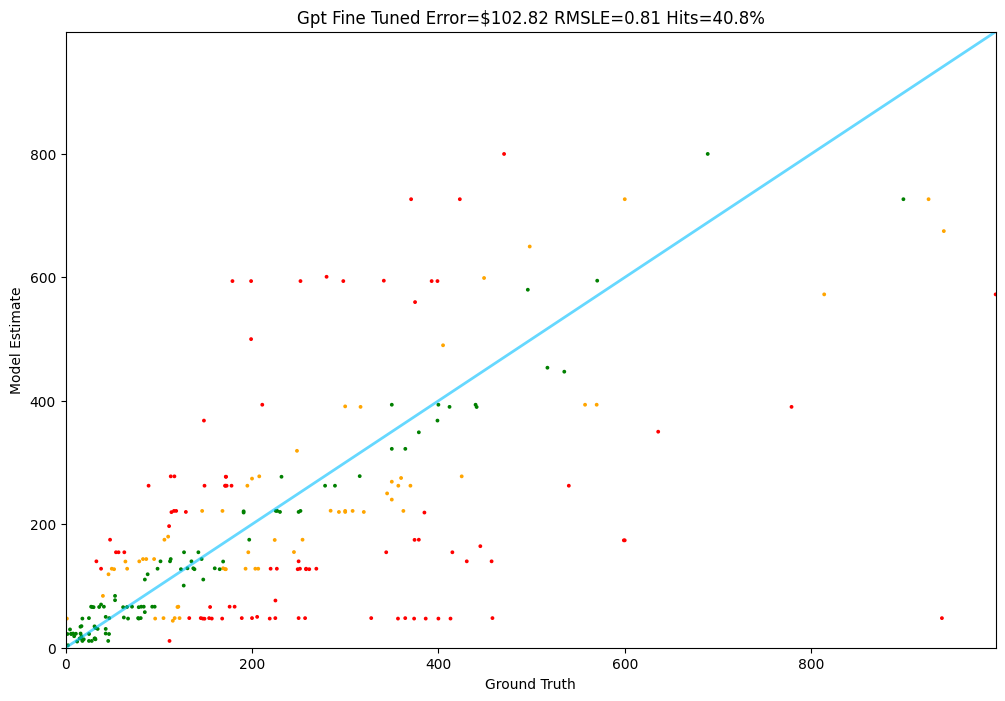

In [39]:
# TestRunnerを実行
Tester.test(gpt_fine_tuned, test)

結果は性能劣化（笑）、トレーニングデータが、テストデータの結果を説明しておらず、また、少量データによる過学習・知識の上書きで、元のLLMが持っていたファインチューニング前の常識のほうが適切だったのかもしれない（♨）ちなみに、OpenAIのファインチューニングは、軽量ファインチューニングと呼ばれ、全パラメータのフルファインチューニングではなく、おそらくLoRAのような軽量手法を内部的に使っていると考えられる（公式には非公開）。